This notebook walks through the analysis of book data and creates some of the figures.

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d
from matplotlib import cm

import itertools
from itertools import combinations
import scipy
from scipy import stats
from scipy.stats import chi2_contingency

## Skip to analysis section if the raw dataset has already been processed


## Prepare raw data
#### From excel, save the csv to utf-8 then import, make sure col headings are good too

In [3]:
df = pd.read_csv('bookData.csv')
# check the data frame info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cataloger         1013 non-null   object
 1   bookid            1013 non-null   object
 2   count             1013 non-null   int64 
 3   title             1013 non-null   object
 4   author            997 non-null    object
 5   combinedName      980 non-null    object
 6   authorOfColor     1013 non-null   int64 
 7   nonPersonAuthor   1013 non-null   int64 
 8   yrpub             1013 non-null   object
 9   neighborhood      1013 non-null   object
 10  collection        1013 non-null   object
 11  age               1013 non-null   object
 12  type              1013 non-null   object
 13  category1         1013 non-null   object
 14  category1Code     1003 non-null   object
 15  subjects          472 non-null    object
 16  deweywording      847 non-null    object
 17  category2     

In [4]:
#Convert Date to Number after removing the question marks (making them NaN)
df['yrpub'] = df['yrpub'].replace('?',None)
df['yrpub']=df['yrpub'].astype(int)
df.yrpub.unique()

array([1999, 2015, 1992, 2012, 1961, 1988, 1985, 2019, 1976, 1991, 2007,
       2004, 1997, 1998, 1989, 1996, 2005, 2001, 1975, 1990, 2017, 1983,
       1979, 1946, 2000, 2003, 2018, 2006, 2009, 1993, 1980, 1994, 1984,
       1967, 2002, 1974, 2016, 2008, 1982, 2011, 1963, 1987, 2013, 1950,
       2014, 1960, 1937, 1977, 1954, 1986, 1981, 1971, 1995, 2010, 1949,
       1970, 1962, 1928, 1978, 1966, 1965, 1969, 1964, 1959, 1968, 1958,
       1972, 1973])

###  Group the categorical and numeric columns

In [5]:
numerical = [
  'yrpub','count','authorOfColor','nonPersonAuthor'
]
categorical = [
  'neighborhood','collection','type','age','category1','category2','category1Code','languages','originalLang'
]

bks = df[numerical + categorical]
bks.shape

(1013, 13)

In [6]:
bks['collection'].head()

0    CentralDistrict3
1          Northgate3
2      Phinney-Green3
3      Phinney-Green4
4      Phinney-Green2
Name: collection, dtype: object

In [7]:
bks.yrpub.max()

2019

(1900.0, 2020.0)

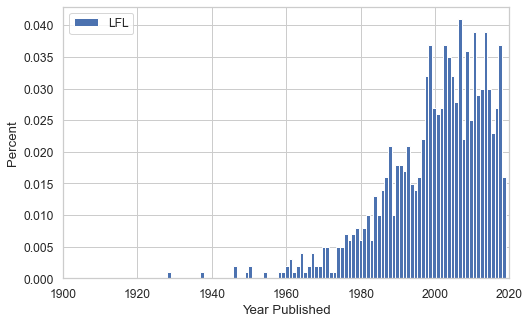

In [8]:
#'Density' Histogram of year published using mtlabplot
#yrhist = bks['yrpub'].plot.hist(bins=50)
#Same thing using seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    bks['yrpub'], norm_hist=True, kde=False, bins=92, hist_kws={"alpha": 1}
).set(xlabel='Year Published', ylabel='Percent')

plt.legend(labels=['LFL'])
#plt.legend('ABCDEF', ncol=2, loc='upper left')

plt.xlim(1900, 2020)

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Year Published')]

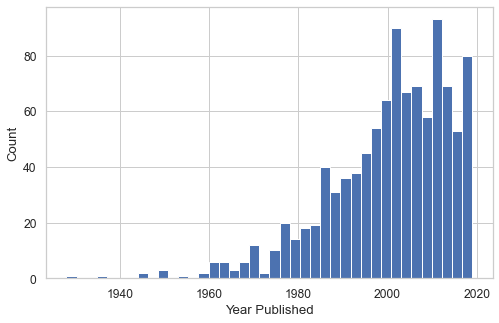

In [9]:
#Histogram of year published using mtlabplot
#yrhist = bks['yrpub'].plot.hist(bins=50)
#Same thing using seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    bks['yrpub'], norm_hist=False, kde=False, bins=40, hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Count')


In [9]:
#export csv for use with SPL data in Get-SPL-data-by-hood ipynb file: 
bks.to_csv('LFL-books-years.csv', mode = 'w', index=False)

### If you are running the entire analysis for the first time, switch to the Get-SPL-data-by-hood Jupyter notebook in the publicLibraryComparison folder.
That creates several csv files need to make charts below. Specifically the percent fiction and percent juvenile charts.

# Start Analysis

In [2]:
#SKIP this cell if you are running the whole script from the start 
#Open LFL cleaned above data and the stat dataset.  These are combined in various ways below.

bks = pd.read_csv('LFL-books-years.csv',encoding='utf-8')
bksctstat = pd.read_csv('bkstats.csv',encoding='utf-8')
dfstats = pd.read_csv('lfl-stats.csv')
bks.head()

,yrpub,count,authorOfColor,nonPersonAuthor,neighborhood,collection,type,age,category1,category2,category1Code,languages,originalLang
0,2006,1,0,0,Central District,CentralDistrict6,Fiction,Adult,Novel,Null,NOV,English,English
1,1992,1,0,0,Montlake,Montlake4,Nonfiction,Adult,Self Help/Health,Null,SH,English,English
2,1999,1,1,0,Phinney-Greenwood,Phinney-Green4,Fiction,Adult,Novel,Null,NOV,English,English
3,2014,1,0,0,Montlake,Montlake4,Fiction,Adult,Mystery,Null,MYS,English,English
4,2017,1,0,0,Northgate,Northgate5,Fiction,Adult,Mystery,Null,MYS,English,English


## Fiction by neighborhood


In [10]:
#Set up the Dataframe

#Groups count by Neighborhood, collection, and type (fiction or non fiction), calculate percent
bksfiction = bks.groupby(['neighborhood','collection', 'type'])['count'].sum().reset_index()
bksfiction['total'] = bksfiction.groupby('collection')['count'].transform('sum')
bksfiction['percent'] = bksfiction['count']/bksfiction['total']


#Select fiction
fic = bksfiction.loc[bksfiction['type']=='Fiction'].copy() #adding the .copy() gets rid of the settingwithcopywarning

#Sort and reindex so that the chart goes low to high
fic['median'] = fic.groupby('neighborhood')['percent'].transform('median')
fic = fic.sort_values(by=['median'], ascending=True).reset_index()


In [11]:
#Set up table for Chi Square to compare fiction proportion between neighborhoods
fichood = fic.groupby('neighborhood').agg({'count':'sum', 'total': 'sum'}).reset_index()
fichood.head()
ficTotal = fichood['count'].sum()
totBks = fichood['total'].sum()
fichood['expCount']= (ficTotal*fichood['total'])/totBks #Only need if using chisquare, not chi2: expected value is row total times col total divided by grand total. Accounts for different number of books
fichood['nonficCount']= fichood['total'] - fichood['count']
fichood.head()

,neighborhood,count,total,expCount,nonficCount
0,Central District,59,93,62.123260,34
1,Columbia City,51,79,52.771372,28
2,Laurelhurst,63,91,60.787276,28
3,Montlake,34,81,54.107356,47
4,Northgate,143,240,160.318091,97


In [12]:
#Open SPL fiction dataframe from the Get-SPL-Book-Data-by-hood jupyter file
ficSPL = pd.read_csv('../publicLibraryComparison/SPL-fiction.csv',encoding='utf-8')
ficSPL.head(10)

,neighborhood,type,count,total,percent
0,Central District,Fiction,23003,49029,0.469171
1,Columbia City,Fiction,14870,26486,0.561429
2,Laurelhurst,Fiction,29836,50942,0.585686
3,Montlake,Fiction,7731,13001,0.594647
4,Northgate,Fiction,16174,27569,0.586673
5,Phinney-Greenwood,Fiction,22772,42934,0.530395
6,Queen Anne,Fiction,10197,18491,0.551457
7,Ravenna,Fiction,29569,51059,0.579114


In [13]:
#Get the medians from the LFL data (fic) and sort so that the points go to the right places
medians = fic[['neighborhood','median']].copy()
medians.drop_duplicates(inplace=True)
medians
ficSPLsorted = pd.merge(medians, ficSPL, on='neighborhood', how='inner')
ficSPLsorted.sort_values(by=['median'], ascending=True)
#ficSPLsorted = ficSPLsorted.fillna('1.2')
ficSPLsorted

,neighborhood,median,type,count,total,percent
0,Montlake,0.494286,Fiction,7731,13001,0.594647
1,Central District,0.616667,Fiction,23003,49029,0.469171
2,Columbia City,0.622159,Fiction,14870,26486,0.561429
3,Northgate,0.653846,Fiction,16174,27569,0.586673
4,Phinney-Greenwood,0.655172,Fiction,22772,42934,0.530395
5,Laurelhurst,0.699248,Fiction,29836,50942,0.585686
6,Queen Anne,0.807692,Fiction,10197,18491,0.551457
7,Ravenna,0.809524,Fiction,29569,51059,0.579114


In [14]:
#Use SciPy to calculate Spearman correlation for median percent fiction in LFLs and percent fiction in nearby public library branch

import scipy
from scipy import stats

#The %.3f' sets the number of decimal places
coef, p = stats.spearmanr(ficSPLsorted['median'],ficSPLsorted['percent'])
print('Spearmans correlation coefficient: %.3f' % coef,' p-value: %.3f' % p)

Spearmans correlation coefficient: -0.119  p-value: 0.779


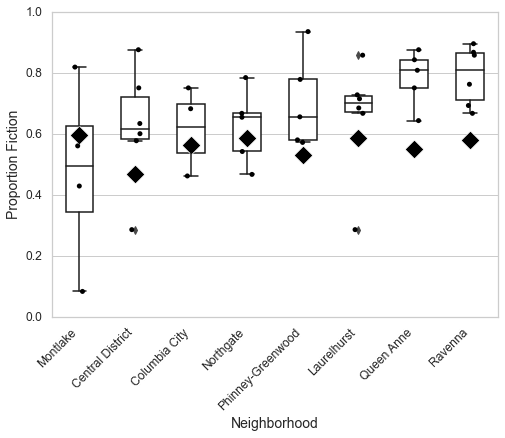

In [15]:
#Make the chart.


#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 8]})
bplot = sns.boxplot(y='percent', x='neighborhood', data=fic,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='percent', x='neighborhood', data=fic, 
                   jitter=True, 
                   marker='o', 
                   alpha=1,
                   color='black')

# SPL fiction percentages
bplot=sns.scatterplot(y='percent', x='neighborhood', data=ficSPLsorted, marker='D', color='#000000', s=175)


#Set y axis label and scale

bplot.set_ylabel("Proportion Fiction",
                fontsize=14)
bplot.set_xlabel("Neighborhood",
                fontsize=14)
bplot.set(ylim=(0, 1))

#rotate labels
for item in bplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right') #This sets horizontal alignment

plt.gcf().subplots_adjust(bottom=0.35) #makes room for the 'tall' x axis lables

#Save figure 
plt.savefig('../figures/fiction.eps')
    

In [16]:
#Chi Square
ficChi= fichood[['count','nonficCount']]
chi2, p, dof, ex = chi2_contingency(ficChi, correction=False) #using chi2 here rather than chisquare because including adult book rather than specifying distribution (expected values)
print("chi: ",chi2,"p-value: ",p,"degrees of freedom: ",dof)

chi:  48.81060731793923 p-value:  2.4712804463033834e-08 degrees of freedom:  7


In [17]:
# gathering all combinations for post-hoc chi2
#Thanks to: https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/
all_combinations = list(combinations(ficChi.index, 2))
print("Significance results:")
for comb in all_combinations:
    # subset df into a dataframe containing only the pair "comb"
    new_df = ficChi[(ficChi.index == comb[0]) | (ficChi.index == comb[1])]
    # running chi2 test
    chi2, p, dof, ex = chi2_contingency(new_df, correction=False)
    print(f"Chi2 result for pair {comb}: {chi2}, p-value: {p}")

Significance results:
Chi2 result for pair (0, 1): 0.0230813781993328, p-value: 0.8792456420559743
Chi2 result for pair (0, 2): 0.6901351095411246, p-value: 0.4061184287559032
Chi2 result for pair (0, 3): 8.017396335454947, p-value: 0.004633012906564043
Chi2 result for pair (0, 4): 0.417958999636728, p-value: 0.5179572246030208
Chi2 result for pair (0, 5): 2.28478442309581, p-value: 0.1306482937282464
Chi2 result for pair (0, 6): 6.316825460630103, p-value: 0.011959755369741466
Chi2 result for pair (0, 7): 7.218202460130156, p-value: 0.007216794122700085
Chi2 result for pair (1, 2): 0.4181827499615641, p-value: 0.5178452122676749
Chi2 result for pair (1, 3): 8.18961296035839, p-value: 0.004213091101864684
Chi2 result for pair (1, 4): 0.6169699225716644, p-value: 0.43217551537659404
Chi2 result for pair (1, 5): 1.5755091220662167, p-value: 0.2094087559498023
Chi2 result for pair (1, 6): 5.120996096060569, p-value: 0.023638044364151588
Chi2 result for pair (1, 7): 5.841491290245537, p-va

In [19]:
#Here's the list of neighborhoods corresponding to above. Bonferonni- 0.05/29=0.00172
#Montlake is different than Phinney, Queen, Laurelhurst, and Ravenna. Northgate is different than Queen Anne and Ravenna.
fichood

,neighborhood,count,total,expCount,nonficCount
0,Central District,59,93,62.123260,34
1,Columbia City,51,79,52.771372,28
2,Laurelhurst,63,91,60.787276,28
3,Montlake,34,81,54.107356,47
4,Northgate,143,240,160.318091,97
5,Phinney-Greenwood,138,191,127.586481,53
6,Queen Anne,85,107,71.475149,22
7,Ravenna,99,124,82.831014,25


## Age by Neighborhood

In [20]:
bks.age.unique()

array(['Adult', 'Young Adult', 'Childrens'], dtype=object)

Text(0, 0.5, 'Number of books')

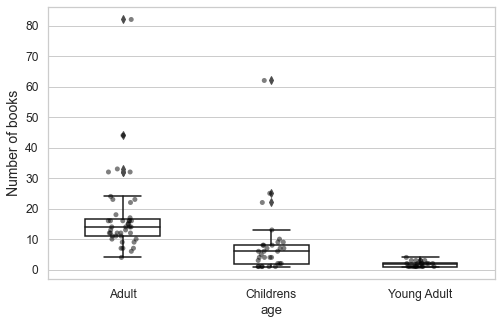

In [21]:
#Groups count by collection and age
bksage = bks.groupby(['neighborhood', 'collection','age'])['count'].sum().reset_index()
#bksage.head()

#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
bplot = sns.boxplot(y='count', x='age', data=bksage,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='count', x='age', data=bksage, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

bplot.set_ylabel("Number of books",
                fontsize=14)

### Juvenile books across neighborhoods
Appears SPL includes teen books in juvenile

In [22]:
#Set up the Dataframe for box and whisker

#Groups count by Neighborhood, collection, and type. 
bksjuvenile = bks.groupby(['neighborhood','collection', 'age'])['count'].sum().reset_index()

#Get the percent juvenile by calculating percent and subracting adult percent from 1
bksjuvenile['total'] = bksjuvenile.groupby('collection')['count'].transform('sum')
bksjuvenile['typepercent'] = bksjuvenile['count']/bksjuvenile['total']
bksjuvenile = bksjuvenile[bksjuvenile.age == 'Adult'] #Select only adult rows
bksjuvenile['juvpercent'] = 1 - bksjuvenile['typepercent'] #calculate juvenile percent, this also puts zero for LFLs with only adult books
bksjuvenile = bksjuvenile.drop(['age'], axis=1) #Drop this column, not needed anymore
bksjuvenile = bksjuvenile.rename(columns={"typepercent": "adultpercent"}) #rename this column since it only shows adult percent now
bksjuvenile = bksjuvenile.rename(columns={"count": "adultcount"})

#Sort and reindex so that the chart goes low to high
juv = bksjuvenile #create a new dataframe just to use an easier name
juv['median'] = juv.groupby('neighborhood')['juvpercent'].transform('median') #For Central, median is zero since three LFLs had zero juv books

juv = juv.sort_values(by=['median'], ascending=True).reset_index()


In [23]:
d = {'adultcount': ['sum'], 'total': ['sum']}
lflJPercent = juv.groupby('neighborhood').agg(d).reset_index() #create totals table
lflJPercent.columns = ['_'.join(col) for col in lflJPercent.columns.values] # flatten MultiIndex columns
lflJPercent = lflJPercent.rename(columns={"neighborhood_": "neighborhood"})
lflJPercent = lflJPercent.rename(columns={"adultcount_sum": "adultcount"})
lflJPercent = lflJPercent.rename(columns={"total_sum": "lfltotal"})
lflJPercent['juvpercent'] = 1 - (lflJPercent['adultcount']/lflJPercent['lfltotal']) #calculate juv percent for neighborhood

In [24]:
#Open SPL fiction dataframe from the Get-SPL-Book-Data-by-hood jupyter file
juvSPL = pd.read_csv('../publicLibraryComparison/SPL-juvenilePercent.csv',encoding='utf-8')
juvSPL.head(8)

,neighborhood,ageletter,count,total,percent
0,Central District,j,20115,49029,0.410267
1,Columbia City,j,11587,26486,0.437476
2,Laurelhurst,j,23079,50942,0.453045
3,Montlake,j,6266,13006,0.481778
4,Northgate,j,11591,27569,0.420436
5,Phinney-Greenwood,j,18297,42934,0.426166
6,Queen Anne,j,7791,18491,0.421340
7,Ravenna,j,22990,51239,0.448682


In [25]:
#Get the medians from the LFL data and sort so that the points go to the right places
mediansjuv = juv[['neighborhood','median']].copy()
mediansjuv.drop_duplicates(inplace=True)
#merge with juvenile percent table
lfldata = pd.merge(lflJPercent, mediansjuv, on='neighborhood', how='inner')
#merge with SPL data
juvSPLsorted = pd.merge(lfldata, juvSPL, on='neighborhood', how='inner')
juvSPLsorted.sort_values(by=['median'], ascending=True)
#juvSPLsorted = juvSPLsorted.fillna('1.2')
juvSPLsorted.head(8)

,neighborhood,adultcount,lfltotal,juvpercent,median,ageletter,count,total,percent
0,Central District,69,93,0.258065,0.000000,j,20115,49029,0.410267
1,Columbia City,64,86,0.255814,0.076923,j,11587,26486,0.437476
2,Laurelhurst,67,91,0.263736,0.178571,j,23079,50942,0.453045
3,Montlake,74,81,0.086420,0.111429,j,6266,13006,0.481778
4,Northgate,158,240,0.341667,0.135135,j,11591,27569,0.420436
5,Phinney-Greenwood,123,191,0.356021,0.362319,j,18297,42934,0.426166
6,Queen Anne,69,107,0.355140,0.375000,j,7791,18491,0.421340
7,Ravenna,96,124,0.225806,0.252381,j,22990,51239,0.448682


In [26]:
#Use Spearman correlation to compare library percent juvenile and LFL median percent 

#The %.3f' sets the number of decimal places
coef, p = stats.spearmanr(juvSPLsorted['juvpercent'],juvSPLsorted['percent'])
print('Spearmans correlation coefficient: %.3f' % coef,' p-value: %.3f' % p)

Spearmans correlation coefficient: -0.548  p-value: 0.160


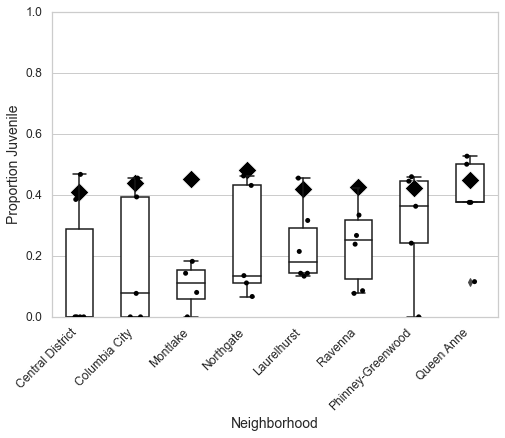

In [27]:
#Make the chart.


#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 8]})
bplot = sns.boxplot(y='juvpercent', x='neighborhood', data=juv,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='juvpercent', x='neighborhood', data=juv, 
                   jitter=True, 
                   marker='o', 
                   alpha=1,
                   color='black')

# SPL juvenile percentages
bplot=sns.scatterplot(y='percent', x='neighborhood', data=juvSPLsorted, marker='D', color='#000000', s=175)


#Set y axis label and scale

bplot.set_ylabel("Proportion Juvenile",
                fontsize=14)
bplot.set_xlabel("Neighborhood",
                fontsize=14)
bplot.set(ylim=(0, 1))



#rotate labels
for item in bplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right') #This sets horizontal alignment

plt.gcf().subplots_adjust(bottom=0.35) #makes room for the 'tall' x axis lables

#Save figure 
plt.savefig('../figures/age.eps')

In [28]:
juvhood = lflJPercent #use dataframe created above
juvhood['count'] =  juvhood['lfltotal'] - juvhood['adultcount']
juvhood.head()

,neighborhood,adultcount,lfltotal,juvpercent,count
0,Central District,69,93,0.258065,24
1,Columbia City,64,86,0.255814,22
2,Laurelhurst,67,91,0.263736,24
3,Montlake,74,81,0.086420,7
4,Northgate,158,240,0.341667,82


In [29]:
#Set up table for Chi Square to compare age proportion between neighborhoods
juvTotal = juvhood['count'].sum()
totBks = juvhood['lfltotal'].sum()
juvhood['expCount']= (juvTotal*juvhood['lfltotal'])/totBks #only need this if doing chisquare rather than chi2: expected value is row total times col total divided by grand total. Accounts for different number of books
juvhood.head(8)

,neighborhood,adultcount,lfltotal,juvpercent,count,expCount
0,Central District,69,93,0.258065,24,26.899309
1,Columbia City,64,86,0.255814,22,24.874630
2,Laurelhurst,67,91,0.263736,24,26.320829
3,Montlake,74,81,0.086420,7,23.428430
4,Northgate,158,240,0.341667,82,69.417572
5,Phinney-Greenwood,123,191,0.356021,68,55.244817
6,Queen Anne,69,107,0.355140,38,30.948667
7,Ravenna,96,124,0.225806,28,35.865745


In [30]:
juvChi = juvhood[['count','adultcount']]
chi2, p, dof, ex = chi2_contingency(juvChi, correction=False) #using chi2 here rather than chisquare because including adult book rather than specifying distribution (expected values)
print("chi: ",chi2,"p-value: ",p)

chi:  29.442417036999178 p-value:  0.00012012911567657509


In [31]:
# gathering all combinations for post-hoc chi2
#Thanks to: https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/
all_combinations = list(combinations(juvChi.index, 2))
print("Significance results:")
for comb in all_combinations:
    # subset df into a dataframe containing only the pair "comb"
    new_df = juvChi[(juvChi.index == comb[0]) | (juvChi.index == comb[1])]
    # running chi2 test
    chi2, p, dof, ex = chi2_contingency(new_df, correction=False)
    print(f"Chi2 result for pair {comb}: {chi2}, p-value: {p}")

Significance results:
Chi2 result for pair (0, 1): 0.001185242371397054, p-value: 0.9725363749043079
Chi2 result for pair (0, 2): 0.007673540880371964, p-value: 0.930195596266824
Chi2 result for pair (0, 3): 8.711252442782097, p-value: 0.003162518600832293
Chi2 result for pair (0, 4): 2.1589451041797925, p-value: 0.1417419700123612
Chi2 result for pair (0, 5): 2.740384262352863, p-value: 0.09784123679734145
Chi2 result for pair (0, 6): 2.1920312758322216, p-value: 0.13872625980781692
Chi2 result for pair (0, 7): 0.30349650349650326, p-value: 0.5816986849638196
Chi2 result for pair (1, 2): 0.014427386767401788, p-value: 0.9043927968773736
Chi2 result for pair (1, 3): 8.341034765419469, p-value: 0.003875951593633555
Chi2 result for pair (1, 4): 2.1480729611543565, p-value: 0.1427489589658645
Chi2 result for pair (1, 5): 2.714710335244495, p-value: 0.099427017851437
Chi2 result for pair (1, 6): 2.195657422190556, p-value: 0.13840014884966884
Chi2 result for pair (1, 7): 0.2520630157539384

While the overall chi square test is significant, even bonferroni corrected, none of the indiv. tests are suggesting the significance is an accumulation of small contributions from combinations rather than a large contribution for any one or more combinations.

In [32]:
#Here's the list of neighborhoods corresponding to above. Bonferonni- 0.05/29=0.00172
juvhood

,neighborhood,adultcount,lfltotal,juvpercent,count,expCount
0,Central District,69,93,0.258065,24,26.899309
1,Columbia City,64,86,0.255814,22,24.874630
2,Laurelhurst,67,91,0.263736,24,26.320829
3,Montlake,74,81,0.086420,7,23.428430
4,Northgate,158,240,0.341667,82,69.417572
5,Phinney-Greenwood,123,191,0.356021,68,55.244817
6,Queen Anne,69,107,0.355140,38,30.948667
7,Ravenna,96,124,0.225806,28,35.865745


## Examine Author Diversity
The list was first compared to two lists crowdsourced on GoodReads (https://www.goodreads.com/list/show/96119._ReadPOC_List_of_Books_by_Authors_of_Color and https://www.goodreads.com/list/show/96282._ReadPOC_List_of_Romance_Books_by_Authors_of_Color). We also researched every author in an attempt to record if they identify as BIPOC.

In [33]:
# Remove non person authors
bksauthors = bks.loc[bks['nonPersonAuthor']==0].copy()
bksauthors.head()

,yrpub,count,authorOfColor,nonPersonAuthor,neighborhood,collection,type,age,category1,category2,category1Code,languages,originalLang
0,1999,1,0,0,Central District,CentralDistrict3,Fiction,Adult,Adventure,Null,ADV,English,English
1,2015,1,0,0,Northgate,Northgate3,Fiction,Adult,Adventure,Religion,ADV,English,English
2,1992,1,0,0,Phinney-Greenwood,Phinney-Green3,Fiction,Young Adult,Adventure,Null,ADV,English,NaN
3,2012,1,0,0,Phinney-Greenwood,Phinney-Green4,Fiction,Adult,Adventure,Null,ADV,English,English
4,1961,1,0,0,Phinney-Greenwood,Phinney-Green2,Fiction,Young Adult,Adventure,Null,ADV,English,NaN


In [34]:
#Some basic stats
aocbooks=bksauthors['authorOfColor'].sum()
totalbks = bksauthors['count'].sum()
aocPercent = aocbooks/totalbks
print(f'Total books: {totalbks}, total authors of color: {aocbooks}, proportion authors of color: {aocPercent}')

Total books: 949, total authors of color: 74, proportion authors of color: 0.0779768177028451


In [35]:
#Percent by neighborhood 
#Groups count by neighborhood, collection, calculate percent
bksauthorshood = bksauthors.groupby(['neighborhood', 'authorOfColor'])['count'].sum().reset_index()
bksauthorshood['total'] = bksauthorshood.groupby('neighborhood')['count'].transform('sum')
bksauthorshood['percent'] = bksauthorshood['count']/bksauthorshood['total']

bksauthorshood = bksauthorshood.loc[bksauthorshood['authorOfColor']==1].copy() #adding the .copy() gets rid of the settingwithcopywarning

#Sort and reindex so that the chart goes low to high
bksauthorshood = bksauthorshood.sort_values(by=['percent'], ascending=True).reset_index()

In [36]:
bksauthorshood.head(8)

,index,neighborhood,authorOfColor,count,total,percent
0,11,Phinney-Greenwood,1,9,177,0.050847
1,7,Montlake,1,4,66,0.060606
2,5,Laurelhurst,1,6,91,0.065934
3,3,Columbia City,1,6,84,0.071429
4,15,Ravenna,1,9,124,0.072581
5,1,Central District,1,6,82,0.073171
6,13,Queen Anne,1,9,102,0.088235
7,9,Northgate,1,25,223,0.112108


In [37]:
print('Total ', bksauthorshood['total'].sum(), ' Authors of color: ', bksauthorshood['count'].sum())

Total  949  Authors of color:  74


In [38]:
#Chi Square. Problem is Central is less than 5 so cannot use.

#from scipy.stats import chisquare
#bksauthorshood['expectedAoc']=bksauthorshood['total']/991*68 #add column of expected number of author of color books
#chisquare(bksauthorshood['count'],f_exp=bksauthorshood['expectedAoc'])


In [40]:
#Percent by LFL and neighborhood

#Groups count by neighborhood, collection, calculate percent
bksauthorsgrp = bksauthors.groupby(['neighborhood','collection', 'authorOfColor'])['count'].sum().reset_index()
bksauthorsgrp['total'] = bksauthorsgrp.groupby('collection')['count'].transform('sum')
bksauthorsgrp['percent'] = bksauthorsgrp['count']/bksauthorsgrp['total']



In [41]:
# I inspected the data and there are no LFLs with 100% authors of color.  To preserve the LFLs with no authors of color
# convert those with 100% white authors to zeros.  Then remove the rows that show percent white authors below 100%
#leaving percent column only percent authors of color

bksauthorsgrp.loc[bksauthorsgrp.percent == 1, 'percent'] = 0
bksaoc = bksauthorsgrp.drop(bksauthorsgrp[(bksauthorsgrp['authorOfColor'] == 0) & (bksauthorsgrp['percent'] > 0)].index)
bksaoc.head()

,neighborhood,collection,authorOfColor,count,total,percent
0,Central District,CentralDistrict1,0,3,3,0.000000
2,Central District,CentralDistrict2,1,2,15,0.133333
3,Central District,CentralDistrict3,0,28,28,0.000000
5,Central District,CentralDistrict4,1,1,22,0.045455
7,Central District,CentralDistrict5,1,2,6,0.333333


In [42]:
#Sort and reindex so that the chart will go low to high
bksaoc['median'] = bksaoc.groupby('neighborhood')['percent'].transform('median')
bksaoc = bksaoc.sort_values(by=['median'], ascending=True).reset_index()
bksaoc.head()

,index,neighborhood,collection,authorOfColor,count,total,percent,median
0,33,Montlake,Montlake6,0,11,11,0.000000,0.020833
1,32,Montlake,Montlake5,1,3,16,0.187500,0.020833
2,30,Montlake,Montlake4,1,1,24,0.041667,0.020833
3,28,Montlake,Montlake2,0,15,15,0.000000,0.020833
4,43,Phinney-Greenwood,Phinney-Green1,0,14,14,0.000000,0.032787


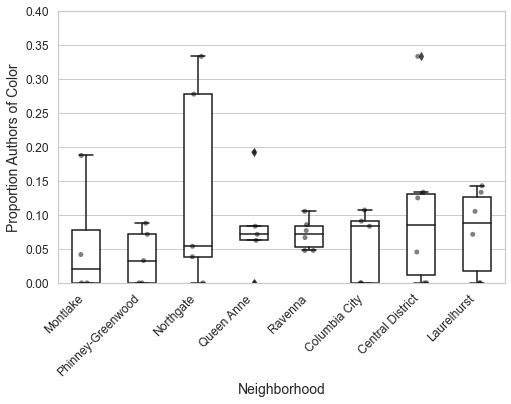

In [43]:
#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

bplot = sns.boxplot(y='percent', x='neighborhood', data=bksaoc,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='percent', x='neighborhood', data=bksaoc, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

#Set y axis label and scale

bplot.set_ylabel("Proportion Authors of Color",
                fontsize=14)
bplot.set_xlabel("Neighborhood",
                fontsize=14)
bplot.set(ylim=(0, 0.4))



#rotate labels
for item in bplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right') #This sets horizontal alignment

### Add in socioeconomic data from census data notebook
The section this produces is a scatterplot of percent authors of color versus gini-simpson index.

In [44]:
dfsocioecon = pd.read_csv('../census/socioeconomic-by-neighborhood.csv', encoding='utf-8')

In [45]:
#Merge with the lfl number dataset
dfAocSocio = pd.merge(bksauthorshood, dfsocioecon, on='neighborhood', how='inner')
dfAocSocio.head()

,index,neighborhood,authorOfColor,count,total,percent,avg-median-income,pop,numlfls,tot,...,afam,amin,as,hw,ot,combo1,combo2,combo3,simpsons,gini-simp
0,11,Phinney-Greenwood,1,9,177,0.050847,96876.333333,23948,20,25401,...,424,85,1668,14,310,1469,94,1375,0.722881,0.277119
1,7,Montlake,1,4,66,0.060606,144488.500000,8644,8,9546,...,109,36,763,38,91,461,60,401,0.721553,0.278447
2,5,Laurelhurst,1,6,91,0.065934,127971.500000,10479,11,11010,...,303,0,1289,13,45,478,0,478,0.669051,0.330949
3,3,Columbia City,1,6,84,0.071429,67992.000000,16883,9,18983,...,5152,159,4960,86,169,1458,0,1458,0.289836,0.710164
4,15,Ravenna,1,9,124,0.072581,101129.833333,24187,24,25957,...,376,58,3135,98,298,1405,85,1320,0.649513,0.350487


In [46]:
#Get rid of extraneous columns
dfAocSocio = dfAocSocio.drop(columns=['tot','wh','afam','amin','as','hw','ot','combo1','combo2','combo3'])

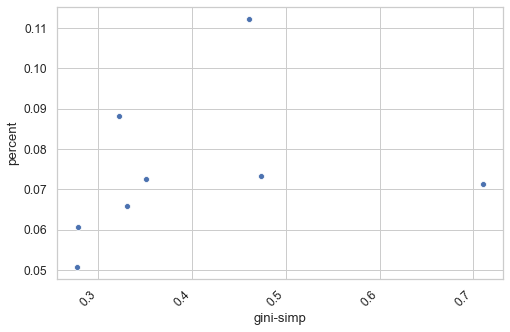

In [47]:
#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

bplot = sns.scatterplot(y='percent', x='gini-simp', data=dfAocSocio)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')


#rotate labels
for item in bplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right') #This sets horizontal alignment

In [48]:
#Spearmans Correlation for all variables in the table
dfAocSocio.corr(method='spearman')

,index,authorOfColor,count,total,percent,avg-median-income,pop,numlfls,simpsons,gini-simp
index,1.000000,NaN,0.650814,0.642857,0.095238,0.166667,0.571429,0.778457,0.523810,-0.523810
authorOfColor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,0.650814,NaN,1.000000,0.951190,0.525657,-0.450564,0.550689,0.805813,0.025031,-0.025031
total,0.642857,NaN,0.951190,1.000000,0.285714,-0.428571,0.404762,0.742528,0.142857,-0.142857
percent,0.095238,NaN,0.525657,0.285714,1.000000,-0.261905,0.309524,0.311383,-0.547619,0.547619
avg-median-income,0.166667,NaN,-0.450564,-0.428571,-0.261905,1.000000,-0.214286,-0.155691,0.571429,-0.571429
pop,0.571429,NaN,0.550689,0.404762,0.309524,-0.214286,1.000000,0.838338,0.047619,-0.047619
numlfls,0.778457,NaN,0.805813,0.742528,0.311383,-0.155691,0.838338,1.000000,0.191620,-0.191620
simpsons,0.523810,NaN,0.025031,0.142857,-0.547619,0.571429,0.047619,0.191620,1.000000,-1.000000
gini-simp,-0.523810,NaN,-0.025031,-0.142857,0.547619,-0.571429,-0.047619,-0.191620,-1.000000,1.000000


In [49]:
#Use SciPy

import scipy
from scipy import stats

#The %.3f' sets the number of decimal places
coef, p = stats.spearmanr(dfAocSocio['gini-simp'],dfAocSocio['percent'])
print('Spearmans correlation coefficient: %.3f' % coef,' p-value: %.3f' % p)

Spearmans correlation coefficient: 0.548  p-value: 0.160


In [50]:
#The %.3f' sets the number of decimal places
coef, p = stats.spearmanr(dfAocSocio['avg-median-income'],dfAocSocio['percent'])
print('Spearmans correlation coefficient: %.3f' % coef,' p-value: %.3f' % p)

Spearmans correlation coefficient: -0.262  p-value: 0.531


## Create dataset with LFL volumes and owner intentions.
Ultimate Dataframe = bksctstat
Set up a seperate csv with lfl volume and house price. Make sure all numerical columns are number format. Year is okay as int

In [51]:
#Only do this if you are running from the beginning
dfstats = pd.read_csv('lfl-stats.csv')

In [52]:
dfstats['vol'] = (dfstats['width']*dfstats['length']*dfstats['height']/1728) #add a vol column with cubic feet units
dfstats = dfstats[np.isfinite(dfstats['vol'])] #Keep rows that have vol
dfstats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   collection  42 non-null     object 
 1   width       42 non-null     float64
 2   length      42 non-null     float64
 3   height      42 non-null     int64  
 4   volMeters   42 non-null     float64
 5   adjPrice    38 non-null     float64
 6   specific    42 non-null     object 
 7   current     42 non-null     object 
 8   variety     42 non-null     object 
 9   kids        42 non-null     object 
 10  religion    42 non-null     object 
 11  porn        42 non-null     object 
 12  vol         42 non-null     float64
dtypes: float64(5), int64(1), object(7)
memory usage: 4.6+ KB


In [53]:
#Groups count by collection
bksct = bks.groupby(['neighborhood','collection'])['count'].sum().reset_index()
bksct.head()

,neighborhood,collection,count
0,Central District,CentralDistrict1,4
1,Central District,CentralDistrict2,16
2,Central District,CentralDistrict3,30
3,Central District,CentralDistrict4,26
4,Central District,CentralDistrict5,7


### Books per Volume

In [54]:
#Create a new dataframe of book counts and lfl stats. Inner join is intersection so removes rows with no partner in other dataframe
bksctstat = pd.merge(dfstats, bksct, on='collection', how='inner')

In [55]:
bksctstat.head()
# The vol column is cubic feet

,collection,width,length,height,volMeters,adjPrice,specific,current,variety,kids,religion,porn,vol,neighborhood,count
0,CentralDistrict1,0.0,0.0,0,0.000000,0.0000,n,n,n,n,n,n,0.000000,Central District,4
1,CentralDistrict2,22.0,11.0,12,0.047588,536554.0424,n,n,n,n,n,n,1.680556,Central District,16
2,CentralDistrict3,23.0,11.0,14,0.058043,124155.9225,n,n,n,n,n,n,2.049769,Central District,30
3,CentralDistrict4,16.0,13.5,21,0.074332,437730.5987,n,n,n,n,y,n,2.625000,Central District,26
4,CentralDistrict5,13.0,14.5,12,0.037067,827225.2702,n,n,y,y,n,n,1.309028,Central District,7


In [56]:
bksctstat['bkPerVol'] = bksctstat['count']/bksctstat['vol']
bksctstat.head(5)

,collection,width,length,height,volMeters,adjPrice,specific,current,variety,kids,religion,porn,vol,neighborhood,count,bkPerVol
0,CentralDistrict1,0.0,0.0,0,0.000000,0.0000,n,n,n,n,n,n,0.000000,Central District,4,inf
1,CentralDistrict2,22.0,11.0,12,0.047588,536554.0424,n,n,n,n,n,n,1.680556,Central District,16,9.520661
2,CentralDistrict3,23.0,11.0,14,0.058043,124155.9225,n,n,n,n,n,n,2.049769,Central District,30,14.635799
3,CentralDistrict4,16.0,13.5,21,0.074332,437730.5987,n,n,n,n,y,n,2.625000,Central District,26,9.904762
4,CentralDistrict5,13.0,14.5,12,0.037067,827225.2702,n,n,y,y,n,n,1.309028,Central District,7,5.347480


In [61]:
bksctstat.head(6)

,collection,width,length,height,volMeters,adjPrice,specific,current,variety,kids,religion,porn,vol,neighborhood,count,bkPerVol,medianVol
0,CentralDistrict1,0.0,0.0,0,0.000000,0.0000,n,n,n,n,n,n,0.000000,Central District,4,NaN,9.520661
1,CentralDistrict2,22.0,11.0,12,0.047588,536554.0424,n,n,n,n,n,n,1.680556,Central District,16,9.520661,9.520661
2,CentralDistrict3,23.0,11.0,14,0.058043,124155.9225,n,n,n,n,n,n,2.049769,Central District,30,14.635799,9.520661
3,CentralDistrict4,16.0,13.5,21,0.074332,437730.5987,n,n,n,n,y,n,2.625000,Central District,26,9.904762,9.520661
4,CentralDistrict5,13.0,14.5,12,0.037067,827225.2702,n,n,y,y,n,n,1.309028,Central District,7,5.347480,9.520661
5,CentralDistrict6,16.5,9.0,20,0.048670,479452.9534,n,y,n,n,n,n,1.718750,Central District,10,5.818182,9.520661


In [57]:
totalbooks=bksctstat['count'].sum()
totalvol = bksctstat['vol'].sum()
bkdensity = totalbooks/totalvol
print(bkdensity)

7.412434450426342


In [58]:
#There is one LFL with no volume so it's density is 'inf'. Set that to null
bksctstat = bksctstat.replace(np.inf, np.nan)

In [59]:
#Look at range
print("Range books per cubic foot",bksctstat['bkPerVol'].min()," - ",bksctstat['bkPerVol'].max())

Range books per cubic foot 3.1973684210526314  -  22.2


In [60]:
bksctstat['medianVol'] = bksctstat.groupby('neighborhood')['bkPerVol'].transform('median')
mediansVol = bksctstat[['neighborhood','medianVol']].copy()
mediansVol.drop_duplicates(inplace=True)
mediansVol

,neighborhood,medianVol
0,Central District,9.520661
6,Columbia City,7.233909
11,Laurelhurst,7.132591
17,Montlake,11.760000
21,Northgate,10.633846
26,Phinney-Greenwood,9.376534
31,Queen Anne,9.047966
36,Ravenna,9.926579


[Text(0, 0.5, 'Books per Cubic Foot'),
 Text(0.5, 0, 'Seattle Little Free Libraries')]

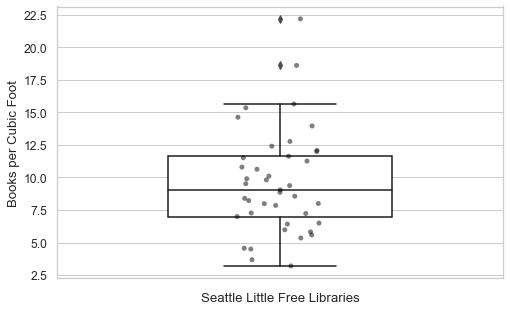

In [62]:
#Plots using Seaborn
bksctstatplot = sns.boxplot(y='bkPerVol', data=bksctstat,
                 width=0.5)
#                palette="colorblind")

#Remove default colors 
plt.setp(bksctstatplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bksctstatplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bksctstatplot =sns.stripplot(y='bkPerVol', data=bksctstat, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

bksctstatplot.set(xlabel='Seattle Little Free Libraries', ylabel='Books per Cubic Foot')

In [63]:
#Set up the dataframe to plot median book per volume by neighborhood

#Groups count by Neighborhood, calculate median
bksctstat['median'] = bksctstat.groupby('neighborhood')['bkPerVol'].transform('median')
bksctstat = bksctstat.sort_values(by=['median'], ascending=True).reset_index()
bksctstat.head(1)

,index,collection,width,length,height,volMeters,adjPrice,specific,current,variety,kids,religion,porn,vol,neighborhood,count,bkPerVol,medianVol,median
0,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,n,n,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591


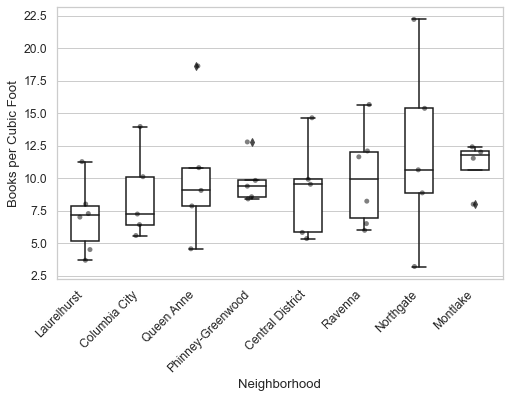

In [64]:
#Plots using Seaborn


bksctstatplot = sns.boxplot(y='bkPerVol', x='neighborhood', data=bksctstat,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bksctstatplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bksctstatplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bksctstatplot=sns.stripplot(y='bkPerVol', x='neighborhood', data=bksctstat, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

bksctstatplot.set(xlabel='Neighborhood', ylabel='Books per Cubic Foot')

#rotate labels
for item in bksctstatplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right')

In [65]:
#Save the file if you need it
bksctstat.to_csv('bkstats.csv', mode = 'w', index=False)

### Checking Preference

#### Checking People's Desires vs the Content - Children

In [66]:
#Create a new dataframe of children's books and lfl stats. Inner join is intersection so removes rows with no partner in other dataframe
bkspref = bks.groupby(['neighborhood', 'collection','age'])['count'].sum().reset_index()
bkschildren = bkspref.loc[bkspref['age']=="Childrens"]
bksstatchil = pd.merge(bksctstat, bkschildren, on='collection', how='inner')
bksstatchil.rename(columns = {'count_x':'total_count'}, inplace = True)
bksstatchil.rename(columns = {'count_y':'chil_count'}, inplace = True)
bksstatchil.rename(columns = {'neighborhood_y':'neighborhood'}, inplace = True)

bksstatchil.head()

,index,collection,width,length,height,volMeters,adjPrice,specific,current,variety,...,porn,vol,neighborhood_x,total_count,bkPerVol,medianVol,median,neighborhood,age,chil_count
0,15,Laurelhurst5,15.0,15.0,15,0.055306,7.225768e+05,n,n,n,...,y,1.953125,Laurelhurst,22,11.264000,7.132591,7.132591,Laurelhurst,Childrens,8
1,16,Laurelhurst6,16.0,12.0,14,0.044048,1.728653e+06,n,n,n,...,n,1.555556,Laurelhurst,7,4.500000,7.132591,7.132591,Laurelhurst,Childrens,1
2,14,Laurelhurst4,19.0,13.0,15,0.060714,2.950734e+05,n,n,n,...,n,2.144097,Laurelhurst,15,6.995951,7.132591,7.132591,Laurelhurst,Childrens,1
3,13,Laurelhurst3,18.0,12.0,19,0.067252,1.162688e+06,n,n,n,...,y,2.375000,Laurelhurst,19,8.000000,7.132591,7.132591,Laurelhurst,Childrens,6
4,12,Laurelhurst2,22.0,13.0,23,0.107794,9.226014e+05,n,n,n,...,n,3.806713,Laurelhurst,14,3.677714,7.132591,7.132591,Laurelhurst,Childrens,2


In [67]:
#Calculate Percent
bksstatchil['percent'] = bksstatchil['chil_count']/bksstatchil['total_count']
bksstatchil[bksstatchil['kids']=='y']

,index,collection,width,length,height,volMeters,adjPrice,specific,current,variety,...,vol,neighborhood_x,total_count,bkPerVol,medianVol,median,neighborhood,age,chil_count,percent
5,11,Laurelhurst1,16.0,13.0,16,0.054536,297957.7826,y,n,n,...,1.925926,Laurelhurst,14,7.269231,7.132591,7.132591,Laurelhurst,Childrens,2,0.142857
20,36,Ravenna1,16.5,11.0,22,0.065433,769793.5977,n,n,y,...,2.310764,Ravenna,19,8.222389,9.926579,9.926579,Ravenna,Childrens,7,0.368421
21,38,Ravenna3,17.0,17.0,21,0.099453,951033.2598,n,n,n,...,3.512153,Ravenna,21,5.979239,9.926579,9.926579,Ravenna,Childrens,4,0.190476
27,21,Northgate1,15.0,13.0,15,0.047932,NaN,y,n,n,...,1.692708,Northgate,26,15.360000,10.633846,10.633846,Northgate,Childrens,10,0.384615
29,19,Montlake5,15.0,13.0,15,0.047932,714970.7298,y,n,n,...,1.692708,Montlake,21,12.406154,11.760000,11.760000,Montlake,Childrens,2,0.095238


In [68]:
#Mean percent by whether they do not want religios books or na.  Need to compare to total mean.  Will need to create new dataframe.
bksstatchilcomp = bksstatchil.groupby(['kids'])['percent'].mean().reset_index()
bksstatchilcomp.head()

,kids,percent
0,n,0.252169
1,y,0.236322


In [69]:
#Get percents with zero values

bksagestat = pd.merge(bksctstat, bkspref, on='collection', how='inner')
#Calculate Percent
bksagestat['percent'] = bksagestat['count_y']/bksagestat['count_x']
#Get only childrens- should be one line for every collection with childrens material
bksagestatchil = bksagestat.loc[bksagestat['age']=="Childrens"]
#Get only the collection and percent columns
bksagestatchil = bksagestatchil[['collection','kids','percent']]
#Create dataframe of just collections
collections = bksctstat[['collection']]
#Merge to add the collections with no religious material and then convert NaNs to zero
percentschil = pd.merge(collections, bksagestatchil, on='collection', how='outer')
percentschil.fillna(0, inplace = True)

In [70]:
percentschil.head()

,collection,kids,percent
0,Laurelhurst5,n,0.363636
1,Laurelhurst6,n,0.142857
2,Laurelhurst4,n,0.066667
3,Laurelhurst3,n,0.315789
4,Laurelhurst2,n,0.142857


In [71]:
#For overall percent of children's books
#Get percents for each category
#Group by category
bksagepercent = bks.groupby(['age'])['count'].sum().reset_index()
#Get total
bkscatTotal = bks['count'].sum()
#create a percent column
bksagepercent['percent'] = bksagepercent['count']/bkscatTotal
#Sort by the percent
bksagepercent.sort_values(by='percent', ascending=False, inplace=True)
bksagepercent.head(15)

,age,count,percent
0,Adult,720,0.710760
1,Childrens,249,0.245805
2,Young Adult,44,0.043435


In [72]:
#Average percent children's material when kids material was present
print(bksagestatchil['percent'].mean())

0.24961267545926555


In [73]:
#Average percent childrens books in lfls incl zeros
percentschil['percent'].mean()

0.184237927124696

In [74]:
#t-test

from scipy.stats import ttest_ind

cat1 = percentschil[percentschil['kids']=='y']
cat2 = percentschil[percentschil['kids']=='n']

ttest_ind(cat1['percent'], cat2['percent'])

Ttest_indResult(statistic=-0.2302846183737692, pvalue=0.8194873708648105)

In [75]:
#These are the same numbers as the groupby calculation above.
print(cat1['percent'].mean())
print(cat2['percent'].mean())

0.23632157316367844
0.2521686566699554


#### Checking People's Desires vs the Content - Religion
This is tough because most who say they don't want religious texts, don't have any so there are a lot of zeros.  Those get dropped in the inner join.
Best thing to do would be just report religion as exists or not.

In [76]:
#Create a new dataframe of religion books and lfl stats. Inner join is intersection so removes rows with no partner in other dataframe
bkscategory = bks.groupby(['neighborhood', 'collection','category1'])['count'].sum().reset_index()
bksrel = bkscategory.loc[bkscategory['category1']=="Religion"]
bksstatrel = pd.merge(bksctstat, bksrel, on='collection', how='inner')
bksstatrel.rename(columns = {'count_x':'total_count'}, inplace = True)
bksstatrel.rename(columns = {'count_y':'rel_count'}, inplace = True)
bksstatrel.rename(columns = {'neighborhood_y':'neighborhood'}, inplace = True)
#bksstatrel=bksstatchil.drop('neighborhood_x',1)
bksstatrel.head()

,index,collection,width,length,height,volMeters,adjPrice,specific,current,variety,...,porn,vol,neighborhood_x,total_count,bkPerVol,medianVol,median,neighborhood,category1,rel_count
0,15,Laurelhurst5,15.0,15.00,15,0.055306,7.225768e+05,n,n,n,...,y,1.953125,Laurelhurst,22,11.264000,7.132591,7.132591,Laurelhurst,Religion,1
1,16,Laurelhurst6,16.0,12.00,14,0.044048,1.728653e+06,n,n,n,...,n,1.555556,Laurelhurst,7,4.500000,7.132591,7.132591,Laurelhurst,Religion,1
2,8,ColumbiaCity3,21.0,12.00,19,0.078461,1.624933e+05,n,n,n,...,n,2.770833,Columbia City,28,10.105263,7.233909,7.233909,Columbia City,Religion,1
3,6,ColumbiaCity1,15.5,10.75,21,0.057340,2.397767e+05,n,n,n,...,n,2.024957,Columbia City,13,6.419891,7.233909,7.233909,Columbia City,Religion,1
4,35,QueenAnne5,13.5,11.00,15,0.036502,2.483296e+05,n,n,n,...,y,1.289062,Queen Anne,24,18.618182,9.047966,9.047966,Queen Anne,Religion,1


In [77]:
#Calculate Percent
bksstatrel['percent'] = bksstatrel['rel_count']/bksstatrel['total_count']
bksstatrel[bksstatrel['religion']=='y']

,index,collection,width,length,height,volMeters,adjPrice,specific,current,variety,...,vol,neighborhood_x,total_count,bkPerVol,medianVol,median,neighborhood,category1,rel_count,percent
8,29,Phinney-Green4,22.0,15.0,25,0.135193,445509.3815,n,n,n,...,4.774306,Phinney-Greenwood,61,12.776727,9.376534,9.376534,Phinney-Greenwood,Religion,2,0.032787
10,3,CentralDistrict4,16.0,13.5,21,0.074332,437730.5987,n,n,n,...,2.625000,Central District,26,9.904762,9.520661,9.520661,Central District,Religion,3,0.115385
15,22,Northgate2,12.0,12.0,20,0.047195,335916.4340,y,n,n,...,1.666667,Northgate,37,22.200000,10.633846,10.633846,Northgate,Religion,4,0.108108


[Text(0, 0.5, 'Percent religious books in LFL'),
 Text(0.5, 0, 'Steward reports removing religious books')]

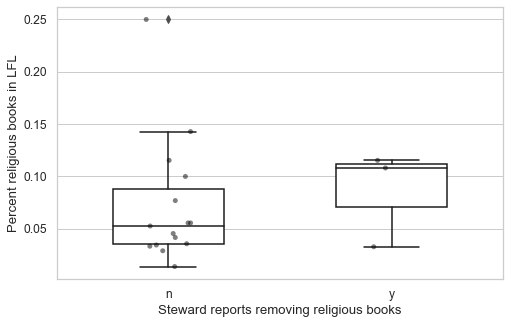

In [78]:
#Plots using Seaborn


bksstatrelplot = sns.boxplot(y='percent', x='religion', data=bksstatrel,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bksstatrelplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bksstatrelplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bksstatrelplot=sns.stripplot(y='percent', x='religion', data=bksstatrel, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

bksstatrelplot.set(xlabel='Steward reports removing religious books', ylabel='Percent religious books in LFL')


In [79]:
bkscatstat = pd.merge(bksctstat, bkscategory, on='collection', how='inner')
#Calculate Percent
bkscatstat['percent'] = bkscatstat['count_y']/bkscatstat['count_x']
#Get only religion- should be one line for every collection with religious material
bkscatstatrel = bkscatstat.loc[bkscatstat['category1']=="Religion"]
#Get only the collection and percent columns
bkscatstatrel = bkscatstatrel[['collection','percent']]
#Create dataframe of just collections
collections = bksctstat[['collection']]
#Merge to add the collections with no religious material and then convert NaNs to zero
percentsrel = pd.merge(collections, bkscatstatrel, on='collection', how='outer')
percentsrel.fillna(0, inplace = True)

In [80]:
#For overall percent religious material
#Get percents for each category
#Group by category
bksoverallpercent = bks.groupby(['category1'])['count'].sum().reset_index()
#Get total
bkscatTotal = bks['count'].sum()
#create a percent column
bksoverallpercent['percent'] = bksoverallpercent['count']/bkscatTotal
#Sort by the percent
bksoverallpercent.sort_values(by='percent', ascending=False, inplace=True)
bksoverallpercent.head(15)


,category1,count,percent
28,Null,243,0.239882
26,Mystery,99,0.097730
40,Thriller/Suspense,80,0.078973
38,Self Help/Health,68,0.067127
36,SciFi/Fantasy,60,0.059230
18,Historical Fiction,43,0.042448
3,Biography/Autobiography/Memoir,42,0.041461
33,Romance,40,0.039487
11,Cookery,36,0.035538
14,Domestic Fiction,33,0.032577


In [81]:
#Average percent religious books in lfls incl zeros
percentsrel['percent'].mean()

0.03187412190206492

In [82]:
#Percent religious material when religious material was present
print(bksstatrel['percent'].mean())

0.07437295110481813


In [83]:
#t-test

from scipy.stats import ttest_ind

cat1 = bksstatrel[bksstatrel['religion']=='y']
cat2 = bksstatrel[bksstatrel['religion']=='n']

ttest_ind(cat1['percent'], cat2['percent'])

Ttest_indResult(statistic=0.35588871929823385, pvalue=0.7265728734837091)

# Bray Curtis Dissimilarity for Cluster Analysis
### Prepare dataframe for Bray Curtis dissimilarity
This sets up a dataframe that is formatted for a more efficient analysis in R. Could not figure out how to do cluster analysis with Python.

In [ ]:
#Get percents of category1 by LFL. This is to compare what stewards say to what is in their library
bkscatlflct = bks

#Replace 'Null' with 'Childrens'
bkscatlflct['category1'] = np.where(bkscatlflct['age'] =='Childrens', 'Childrens', bkscatlflct['category1'])

bkscatlflct = bkscatlflct.groupby(['neighborhood','collection', 'category1'])['count'].sum().reset_index()

bkscatlflct = bkscatlflct.rename(columns={'collection': 'lflname'}) #changing name because this is also an index?



In [85]:
#Change the collection column to lflname in the dataframe with volume
bksctstatbc = bksctstat.rename(columns={'collection': 'lflname'})
bksctstatbc = bksctstatbc[['lflname','volMeters']]

#Merge the dataframes
bkscatlflctvol = pd.merge(bkscatlflct, bksctstatbc, on='lflname', how='inner')

#Remove the LFLs with no volume measurement
bkscatlflctvol = bkscatlflctvol[bkscatlflctvol['volMeters'] > 0]

#Calculate book per vol
bkscatlflctvol['density'] = bkscatlflctvol['count']/bkscatlflctvol['volMeters']

In [86]:
#Create dataframe to add in neighborhood column later
hoodscol = bks[['neighborhood', 'collection']].reset_index() #messy but works
hoodscol = hoodscol.rename(columns={'collection': 'lflname'})
hoodscol = hoodscol.drop(columns=['index'])
hoodscol = hoodscol.drop_duplicates()

In [87]:
#Set up the final file

#Unstack the opposite way for use in R
bkscatlflctvolwide = bkscatlflctvol[['lflname','category1','density']]
bkscatlflctvolwide = bkscatlflctvolwide.pivot(index='lflname',columns="category1", values='density')
bkscatlflctvolwide = bkscatlflctvolwide.fillna(0)

#merge to get the neighborhoods as a column
bkscatlflctvolwide = pd.merge(hoodscol, bkscatlflctvolwide, on='lflname', how='inner')

In [88]:
bkscatlflctvolwide.head()

,neighborhood,lflname,Adventure,Anthology/Essays/Short stories,Art,Biography/Autobiography/Memoir,Black Humour,Business/Technology,Canadian Fiction,Childrens,...,Romance,SCIFI/Fantasy,SCiFi/Fantasy,SciFi/Fantasy,Science,Self Help/Health,Sports,Thriller/Suspense,Travel,Western
0,Central District,CentralDistrict3,17.228606,0.000000,0.000000,51.685819,0.0,0.000000,0.0,223.971883,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,51.685819,0.000000,0.0
1,Northgate,Northgate3,0.784126,0.784126,0.784126,3.920631,0.0,0.000000,0.0,48.615821,...,2.352378,0.0,0.0,6.273009,1.568252,5.488883,5.488883,3.920631,0.784126,0.0
2,Phinney-Greenwood,Phinney-Green3,4.798971,0.000000,0.000000,4.798971,0.0,0.000000,0.0,105.577364,...,4.798971,0.0,0.0,14.396913,0.000000,52.788682,4.798971,9.597942,9.597942,0.0
3,Phinney-Greenwood,Phinney-Green4,7.396833,14.793665,0.000000,0.000000,0.0,0.000000,0.0,184.920817,...,14.793665,0.0,0.0,22.190498,0.000000,7.396833,0.000000,51.777829,0.000000,0.0
4,Phinney-Greenwood,Phinney-Green2,10.427855,0.000000,0.000000,0.000000,0.0,10.427855,0.0,52.139274,...,20.855710,0.0,0.0,10.427855,0.000000,72.994984,0.000000,10.427855,0.000000,0.0


In [89]:
#Save csv file for use in R
bkscatlflctvolwide.to_csv('cluster/cat-density-collection.csv', mode = 'w', index=False)

## Categories by Neighborhood



In [90]:
#Look at general categories
bkscatgen = bks

#Replace 'Null' with 'Childrens'
bkscatgen['category1'] = np.where(bkscatgen['age'] =='Childrens', 'Childrens', bkscatgen['category1'])

#Group by category
bkscatgen = bks.groupby(['category1'])['count'].sum().reset_index()

#Get total
bkscatTotal = bkscatgen['count'].sum()
#create a percent column
bkscatgen['percent'] = bkscatgen['count']/bkscatTotal
#Sort by the percent
bkscatgen.sort_values(by='percent', ascending=False, inplace=True)
bkscatgen.head(15)


<ipython-input-90-0ee86ab9680d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bkscatgen['category1'] = np.where(bkscatgen['age'] =='Childrens', 'Childrens', bkscatgen['category1'])


,category1,count,percent
7,Childrens,249,0.245805
27,Mystery,99,0.097730
40,Thriller/Suspense,80,0.078973
38,Self Help/Health,68,0.067127
36,SciFi/Fantasy,60,0.059230
19,Historical Fiction,43,0.042448
3,Biography/Autobiography/Memoir,42,0.041461
33,Romance,40,0.039487
12,Cookery,36,0.035538
15,Domestic Fiction,33,0.032577


## Chart top 5 categories

In [93]:
#Get percents of category1 by neighborhood
bkscat = bks.groupby(['neighborhood', 'category1Code'])['count'].sum().reset_index()
#Replace 'Null' with 'Childrens'
bkscat.loc[bkscat.category1Code == 'NU', 'category1Code'] = 'CH'
bkscat.loc[bkscat.category1Code == 'MYS', 'category1Code'] = 'M'
bkscat.loc[bkscat.category1Code == 'SCIFIFAN', 'category1Code'] = 'SF-FAN'
#Create a total column grouped by neighborhood
bkscat['total'] = bkscat.groupby('neighborhood')['count'].transform('sum')
#create a percent column
bkscat['percent'] = bkscat['count']/bkscat['total']
#Sort by the percent
bkscat = bkscat.groupby('neighborhood').apply(pd.DataFrame.sort_values, 'percent', ascending=False)
#Neighborhood column at this point is both the grouping column and a data column, so delete the data one.
#bkscat = bkscat.drop('neighborhood', 1)
bkscat = bkscat.rename(columns={'neighborhood': 'hoodname'})
#Create a cumulative count column by neighborhood
bkscat['cumulct'] = bkscat.groupby(['neighborhood']).cumcount()+1
#Create a new column with the categories not in top 5 categories or over in cumulper marked as 'other'
bkscat['newcat'] = np.where(bkscat['cumulct'] < 6, bkscat['category1Code'], 'Other')
bkscat.head(20)

hoodname category1Code  count  total   percent  \
neighborhood                                                                  
Central District 14  Central District            CH     20     91  0.219780   
                 20  Central District            TH     12     91  0.131868   
                 13  Central District             M      7     91  0.076923   
                 3   Central District           BIO      7     91  0.076923   
                 16  Central District           ROM      7     91  0.076923   
                 15  Central District             R      6     91  0.065934   
                 19  Central District            SH      5     91  0.054945   
                 7   Central District            CS      4     91  0.043956   
                 9   Central District             H      4     91  0.043956   
                 1   Central District            AN      4     91  0.043956   
                 18  Central District        SF-FAN      3     91  0.032967   
                 10  Central District            HF      2     91  0.021978   
                 8   Central District            DF      2     91  0.021978   
                 12  Central District           LOV      1     91  0.010989   
                 11  Central District            JW      1     91  0.010989   
                 6   Central District            CR      1     91  0.010989   
                 5   Central District           CAF      1     91  0.010989   
                 17  Central District             S      1     91  0.010989   
                 4   Central District            BU      1     91  0.010989   
                 2   Central District           ART      1     91  0.010989   

                     cumulct newcat  
neighborhood                         
Central District 14        1     CH  
                 20        2     TH  
                 13        3      M  
                 3         4    BIO  
                 16        5    ROM  
                 15        6  Other  
                 19        7  Other  
                 7         8  Other  
                 9         9  Other  
                 1        10  Other  
                 18       11  Other  
                 10       12  Other  
                 8        13  Other  
                 12       14  Other  
                 11       15  Other  
                 6        16  Other  
                 5        17  Other  
                 17       18  Other  
                 4        19  Other  
                 2        20  Other

In [94]:
#Sum the counts by newcat
bkscatsumall = bkscat.groupby(['neighborhood','newcat'])['count'].sum().reset_index()
bkscatsumall.head(10)

,neighborhood,newcat,count
0,Central District,BIO,7
1,Central District,CH,20
2,Central District,M,7
3,Central District,Other,38
4,Central District,ROM,7
5,Central District,TH,12
6,Columbia City,BIO,6
7,Columbia City,CH,15
8,Columbia City,Other,46
9,Columbia City,SF-FAN,6


### Plot the Categories

In [95]:
catnames = bkscatsumall['newcat'].unique() #Create list of neighborhood names 
#These set up the color scheme for the pie charts
cmap = plt.cm.gist_earth #tab20b (0.1, 0.9)
colors = cmap(np.linspace(0.1, 0.85, len(catnames)))   #0.85 because Ravenna has white slice otherwise
labels = catnames

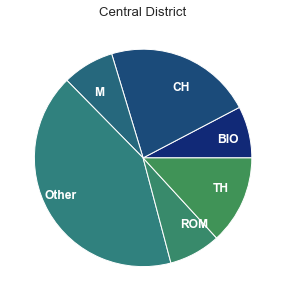

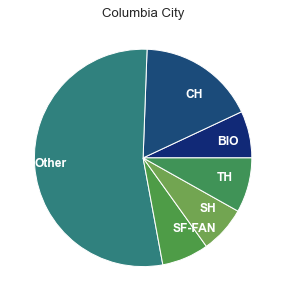

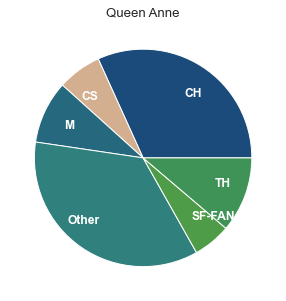

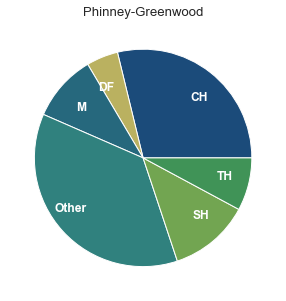

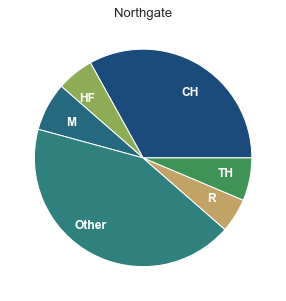

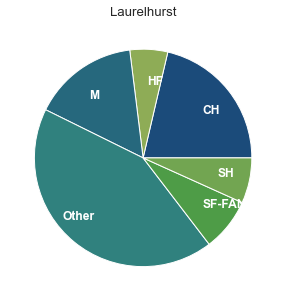

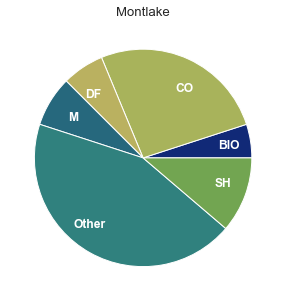

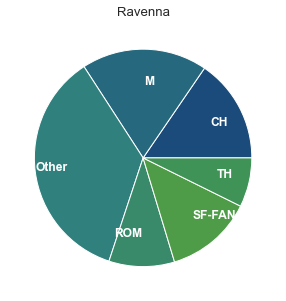

In [96]:
#There's got to be a way to put this all in a loop, but the function mypie assigns colors
#to the slices based on a dictionary so all colors by category are the same.

#https://stackoverflow.com/questions/35206282/assign-specific-colours-to-data-in-matplotlib-pie-chart
#https://matplotlib.org/stable/tutorials/colors/colormaps.html

#This might be a simpler solution!: https://stackoverflow.com/questions/41787006/making-multiple-pie-charts-out-of-a-pandas-dataframe-one-for-each-row

hood='Central District'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/central.eps')

hood1='Columbia City'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood1]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood1

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood1]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/columbia.eps')

hood2='Queen Anne'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood2]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood2

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood2]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/queenanne.eps')

hood3='Phinney-Greenwood'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood3]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood3

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood3]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/phinney.eps')

hood4='Northgate'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood4]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood4

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood4]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/northgate.eps')

hood5='Laurelhurst'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood5]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood5

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood5]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/laurelhurst.eps')

hood6='Montlake'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood6]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood6

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood6]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/montlake.eps')

hood7='Ravenna'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood7]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood7

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood7]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/ravenna.eps')

plt.show()

## Language

In [97]:
bks.head()

,yrpub,count,authorOfColor,nonPersonAuthor,neighborhood,collection,type,age,category1,category2,category1Code,languages,originalLang
0,1999,1,0,0,Central District,CentralDistrict3,Fiction,Adult,Adventure,Null,ADV,English,English
1,2015,1,0,0,Northgate,Northgate3,Fiction,Adult,Adventure,Religion,ADV,English,English
2,1992,1,0,0,Phinney-Greenwood,Phinney-Green3,Fiction,Young Adult,Adventure,Null,ADV,English,NaN
3,2012,1,0,0,Phinney-Greenwood,Phinney-Green4,Fiction,Adult,Adventure,Null,ADV,English,English
4,1961,1,0,0,Phinney-Greenwood,Phinney-Green2,Fiction,Young Adult,Adventure,Null,ADV,English,NaN


In [98]:
bks.originalLang.unique()

array(['English', nan, 'Akkadian', 'Spanish', 'French', 'Japanese',
       'Arabic', 'Latin', 'German', 'Thai', 'Swedish', 'Chinese',
       'Undetermined'], dtype=object)

In [99]:
#Groups count by Neighborhood, collection, and type (fiction or non fiction), calculate percent
bkslang = bks.groupby(['languages'])['count'].sum().reset_index()
#bkslang['total'] = bksfiction.groupby('collection')['count'].transform('sum')
#bkslang['percent'] = bksfiction['count']/bksfiction['total']
bkslang

,languages,count
0,English,954
1,"English, Achinese",2
2,"English, French",2
3,"English, Italian",1
4,"English, Spanish",1
5,"English, Undetermined",2
6,French,2
7,German,1
8,"Hindi, English",1
9,Japanese,1
